##### CSCE 670 :: Information Storage and Retrieval - Final Project Report

<h1><center>Amazon Fake Reviews Classifier and Analysis</center></h1>
<h4><center> Josiah Coad, Savinay Narendra, Sheelabhadra Dey, Chaiwei Chang, Kevin Chang</center></h4>
Github: [Click Me](https://github.com/josiahcoad/Faker)<br>
Data: Please refer to library folder in the repository. (Source: Amazon)<br>


## 1. Introduction

  It has become a common practice for online reviews to have a major impact on the decision of the potential customers of that product. Positive reviews can result in significant financial gains. This gives a strong incentive for fraud reviews, also commonly called opinion scamming. Opinion scamming includes fake blogs, reviews, deceptive advertising and more. Our research is accordingly focusing on product reviews based on the Amazon dataset from Professor Caverlee’s lab at Texas A&M University. Reports indicated 2-6% reviews on average are fake with up to 20% on sites such as Yelp. This leads to an unrealistic representation of places and products on the internet. Additionally, there are some fake review cases in the news for example [6].

  Based on existing machine learnign techniques, we applied unsupervised clustering and observe that whether the spam/fake reviewers can be clustered together. In order to enhance the performance of learning process, we preprocessed the data to focus on suspicious group or individual because we believe that the some obivious features are similar within these groups.
  
  The key difficulty in determining fake reviews is that it is extremely hard for humans to identify fake reviews. In one related work, it was said to take a team of industry experts eight weeks to develop a labeled data set. We believe that a machine can do better at identifying the fake reviews by extracting the implicit information or behavior feature inside the reviews efficiently.





## 2. Data Initialization

To initialize tha data before classifying, we categorized them into groups of members because people who write fake reviews will appear some similar behavior so that this can be a clue that we find them out through group. Afterwards, we explore eight different features on each group and utilize them in the vector space. Now that we have the vector of each group, we implement scaling and normalization to find out the top k, scores of being fake reviewer. Eventually, we feed our input space to Self-Oorganising map(SOM) machine and further observe the result of clustering, and compare the results with  different approaches such as word2vec and basic cosine similarity.



### 2.1 Group Indicator

By grouping our reviewers together in hand tune features of rule-base design, hoping to get a better result of detecting fake review. Here we defined the rules of grouping: (1) If a member rates a certain product with ONE or FIVE stars, he/she is eligible for group. (2) If eligible members commonly rate on the same three or more products, we will form them a group. Note that one member can be in different groups. For example, member A, B, C, and D rate on the same three products i, j, and k as five stars. Therefore, they will form a group. Furthermore, member A, B and C rate products i, j, k, and l as five stars, they will form another group. The condition of rules has the hueristic meaning because one that rate extreme scors may be attempting to make impact on certain product, and if all the members in a group commonly rate on certains product, they has higher probabilities to be conspiracy. By applying these rules, we obtain 1307 different groups and 82577 products that has been rated over once. The related codework is shown on two cells below.


 




In [7]:
from __future__ import print_function
from collections import defaultdict


# returns a list of reviews represented as dict objects.
# put in a number of lines to read from file
# or put in no number and it will read all
def parserJSON(path, numLines=None):
  numLines = numLines or len(open(path).read().split("\n")) - 1
  with open(path) as txt:
    reviews = [eval(next(txt)) for x in range(numLines)]
  print("Number of reviews:", len(reviews))
  return reviews

# create a dict with reviewer ID as key and a list of the reviewers reviews as the value
def get_reviewers(reviews):
   reviewers = {}
   for review in reviews:
      reviewerId = review["memberId"]
      if reviewerId not in reviewers:
         reviewers[reviewerId] = [review]
      else:
         reviewers[reviewerId].append(review)
   print("Number of reviewers:", len(reviewers))
   return reviewers

# takes a list of tuples (reviewer, reviews)
# filter out reviewers who did reviewed less than three products which have been rated 1 or 5 star
# according to the paper, fraud reviewers will review at least three products to get their money's worth
def remove_lessthan3(reviewers_reviews):
   final = {}
   for reviewer, reviews in reviewers_reviews.items():
      reviews = list(filter(lambda review: review["Rate"] == 1 or review["Rate"] == 5, reviews))
      if len(reviews) >= 3:
            final[reviewer] = sorted(reviews, key=lambda review: review["productId"])
   print("Number of reviewers with 3+ reviews rated 1 or 5 star:", len(final))
   return final

# create a dict with product ID as the key and a list of the product's reviews as the value
def get_products(reviews):
   products = {}
   for review in reviews:
      productId = review["productId"]
      if productId not in products:
         products[productId] = [review]
      else:
         products[productId].append(review)
   return products


def normalizedVector(vector):
    total = 0
    for key in vector:
        total += vector[key] ** 2
    total = total ** 0.5
    for key in vector:
        vector[key] /= total
    return vector

# takes a dictionary of groups which are organized by groupID as the key and a list of tuples as the value
# return a list of groups where each group is structured as: [(product, [reviews]), (product, [reviews])]
def organize_by_product(groups_dict):
   group_list = []
   for groupId, group in groups_dict.items():
      reviews = []
      for user, user_reviews in group:
         reviews.extend(user_reviews)
      products_reviews = defaultdict(list)
      for review in reviews:
         products_reviews[review["productId"]].append(review)
      group_list.append( products_reviews.items() )
   return group_list

reviewers_products = []

# get a list of dictionary items which represent each review object (including metadata like product id and user id) 
reviews = parserJSON('./library/amazon-review-data-modified.json')
# get a list of tuples with user as first entry and a list of the review objects their part of as the second
reviewers_reviews_dict = get_reviewers(reviews)
reviewers_reviews = reviewers_reviews_dict
# remove all reviewers who reviewed less than 3 products with ratings other than 1 or 5
reviewers_reviews = remove_lessthan3(reviewers_reviews)

# create a new list of tuples... with first entry being the reviewer 
# and second being a list of the product ids reviewed
for reviewer, reviews in reviewers_reviews.items():
   reviewers_products.append( (reviewer, [review["productId"] for review in reviews]) )

# get a sorted list of reviews that a user left for products which match 'productIds'
def get_product_reviews(productIds, userId):
   return [review for review in reviewers_reviews_dict[userId] if review["productId"] in productIds]

Number of reviews: 99117
Number of reviewers: 4743
Number of reviewers with 3+ reviews rated 1 or 5 star: 3268


#### The eight spam features we applied are describes as below [2]:


<ol>
    <li>Group Time Window (GTW):</li>
    <p>The assumption is that the group tends to work together within a period of time, which means we will give higher scores to those rate the same product within a short time period. In our experiment, we set up the window as four days.</p>
    
\begin{equation*}
    GTW(g, p)=
    \begin{cases}
      0, & \text{if}\ L(g, p) - F(g, p)>\tau \\
      1-\frac{L(g, p) - F(g, p)}{\tau}, & \text{otherwise}
    \end{cases}
\end{equation*}

    <li>Group Deviation (GD):</li>
    <p>If one group has higher deviation with other members' rating on the certain product, they all become suspicious so that we will give them higher score in this indicator</p>
$$D(g, p) = \frac{r_{p,g} - \bar{r}_{p,g}}{4}$$

    <li>Group Content Similarity (GCS):</li>
    <p>This indicatoe capture the similarity of the review text within the group member. Because the fake review may duplicate the review from their member or make a very smilar one.</p>
$$CS_G(g,p)=avg_{m_i,m_j\in g,i < j} \Big( cosine(c(m_i,p),c(m_j,p) \Big)$$

    <li>Group Member Content Similarity (GMCS):</li>
    <p>This feature is similar to the previous one, while this one focuses on the member to similar products. Due to the taxing work of writing a new review, spammer tend to modified the existing fake review and paste on the similar products.</p>
$$CS_M(g,m)=avg_{p_i,p_j\in P_g,i < j} \Big( cosine(c(m,p_i),c(m,p_j) \Big)$$


    <li>Group Early Time Frame (GETF):</li>
    <p>This indicator features the importance of rating time on products, i.e. if one rates a product at the first beginging, it is more suspicious to be fake because it seems to make impact on a product when it has a few rating.</p>
\begin{equation*}
    GTF(g, p)=
    \begin{cases}
      0, & \text{if}\ L(g, p) - A(p)>\beta \\
      1-\frac{L(g, p) - A(p)}{\beta}, & \text{otherwise}
    \end{cases}
\end{equation*}

    <li>Group Size Ratio (GSR):</li>
    <p>This features the ratio of the number of members in a group to the total number of reviews for a certain product. Gigher group ratio means the group dominates the rating and is more likely to be spammer.</p>
$$GSR_p(g,p)= \frac{|g|}{|M_p|}$$

    <li>Group Size (GS):</li>
    <p>For larger groups, members is less likely to be together by chance so that this is a simple intuitive feature.</p>
$$GS(g)= \frac{|g|}{max(|P_{gi}|)}$$

    <li>Group Support Count (GSUP):</li>
    <p>This indicator is the total number of products towards which the group has worked together. Group with higher support count will be given a higher score since they are likely to be spammer. Note that the score is normalized to [0,1].</p>
$$GSUP(g)= \frac{|P_g|}{max(|P_{gi}|)}$$

Note that each value x attained by a feature $f(0 ≤ x ≤ 1)$ as $f \in [0,1]$.
    
</ol>


In [9]:
groups = []
for i in range(len(reviewers_products)-1):
   ref_user = reviewers_products[i]
   newgroup = [ref_user]
   for j in range(i+1, len(reviewers_products)):
      compare_user = reviewers_products[j]
      shared_products = set(ref_user[1]).intersection(set(compare_user[1]))
      if len(shared_products) >= 3:
         newgroup.append(compare_user)
   if len(newgroup) >= 2:
      group_products = sorted(list(set(ref_user[1]).intersection(*[set(user[1]) for user in newgroup])))
      newgroup = [( user[0], get_product_reviews(group_products, user[0]) ) for user in newgroup]
      groups.append(newgroup)
print(*groups[0], sep="\n\n")
print("Number of groups: ", len(groups))


('A2R1SS382YW679', [])

('A135L0KYJC3K4H', [])

('A1NGEEN1F7FVMK', [])

('A3L7Z3ZXGIMWD3', [])
Number of groups:  261


In [11]:
import collections
reviews = parserJSON('./library/amazon-review-data-modified.json')
# get a dict with {user : sorted list (by productId) of their review objects, ...}
user_dict = get_reviewers(reviews)
# remove all reviewers who reviewed less than 3 products with ratings other than 1 or 5
user_dict = remove_lessthan3(user_dict)


# takes a dictionary of users and their products
# returns a dictionary of {group1 : [(userId1, [{R1}, {R2}, ...]), (userId2, [{R1}, {R2}, ...]) ...], ...}
# groups are represented as concatenated productId's of products in that group: "R1-R2-R3"
def group_users(users_dict):
   # get a tuple of... (memberId, list of reviews that a user left for products which match 'productIds')
   def get_entry(memberId, productId_list):
      reviews = [review for review in users_dict[memberId] if review["productId"] in productId_list]
      return ( memberId, reviews )
   # create a list of tuples of... (reviewer, list of the product ids reviewed)
   users = [(memberId, [(review["productId"], review["Rate"]) for review in reviews]) for memberId, reviews in users_dict.items()]# equal to the function of nested loop
   groups = {}
   count = 0
   for i in range(len(users)-1):
      ref_user = users[i]
      for j in range(i+1,len(users)):
         comp_user = users[j]
         common_products = set(ref_user[1]).intersection(set(comp_user[1]))#cmp current and it's next till end
         common_products = sorted([review[0] for review in common_products])#sort by
         if len(common_products) >= 3:
            key = count##intersection
            comp_entry = get_entry(comp_user[0], common_products)
            if key in groups:
               if comp_user[0] not in [entry[0] for entry in groups[key]]: # make sure user's not already in group
                  groups[key].append(comp_entry)
            else:
               ref_entry  = get_entry(ref_user[0] , common_products)
               groups[key] = [ref_entry, comp_entry]
            count += 1

   return groups

with open("./library/groups_temp.txt", "w") as f:
   final_user_dict = collections.OrderedDict(sorted(group_users(user_dict).items()))
   f.write(repr(final_user_dict))

Number of reviews: 99117
Number of reviewers: 4743
Number of reviewers with 3+ reviews rated 1 or 5 star: 3268


In [36]:
from __future__ import print_function
from collections import defaultdict
from cosine_sim import cosine_sim
from numpy import mean as avg
from modules.amazon_parser import *
from collections import OrderedDict


MAX_USERS_IN_GROUP = 5 # found previously
MAX_PRODS_IN_GROUP = 7 # found previously
SIX_MONTHS = 15552000 # seconds in 6 months, used in GETF
FOUR_DAYS = 345600 # number of seconds in 4 days



review_objects = parserJSON('./library/amazon-review-data-modified.json')

products_dict  = get_products(review_objects) # create a dict with product ID as the key and a list of the product's reviews as the value


with open("./library/groups_temp.txt") as f:
   groups = eval(f.read())

groups_by_products = organize_by_product(groups)
groups_by_reviewers = organize_by_user(groups)

# Group Deviation (GD)
def GD(group_by_products):
  return max([D(product, reviews) for product, reviews in group_by_products])

def D(product, reviews):
  group_prod_rate = reviews[0]["Rate"]
  avg_prod_rate = avg([review["Rate"] for review in products_dict[product]])
  return abs(group_prod_rate - avg_prod_rate) / 4.0

# Group Member Content Similarity (GMCS)
def GMCS(groups_by_reviewers):
  return sum([MS(reviews) for reviewer, reviews in groups_by_reviewers]) / len(groups_by_reviewers)

def MS(reviews):
  texts = [review["reviewText"] for review in reviews]
  return avg([cosine_sim(review1, review2) for review1 in texts for review2 in texts])

# Group Size (GS) (number of users in group)
def GS(group_by_users):
    return float(len(group_by_users)) / MAX_USERS_IN_GROUP

# Group Size Ratio (GSR) (returns 1 if each product in the group were only reviewed by the group members)
def GSR(group_by_products):
  return avg ( [gsr(product, reviews) for product, reviews in group_by_products] )

def gsr(product, reviews):
  return float(len(reviews)) / len(products_dict[product])
# ------------------------

def GTW(group):
   return max([prod_TW(reviews) for product, reviews in group])

def prod_TW(reviews):
   timestamps = [float(review["Date"]) for review in reviews]
   _range = max(timestamps)-min(timestamps)
   return 1-_range/FOUR_DAYS if _range <= FOUR_DAYS else 0

def GCS(group):
   return max([CS(reviews) for product, reviews in group])

def CS(reviews):
   texts = [review["reviewText"] for review in reviews]
   return avg([cosine_sim(review1, review2) for review1 in texts for review2 in texts])

def GETF(group):
   return max([GTF(product, reviews) for product, reviews in group])

def GTF(product, reviews):
   earliest_product_review = min([float(review["Date"]) for review in products_dict[product]])
   latest_group_review = max([float(review["Date"]) for review in reviews])
   _range = latest_group_review-earliest_product_review
   return 1-_range/SIX_MONTHS if _range <= SIX_MONTHS else 0

# Group Support Count (GSUP) (number of products in group)
def GSUP(group):
  return float(len(group)) / MAX_PRODS_IN_GROUP

# Sum Scores
def scores(gbp, gbr):
   return [GCS(gbp), GTW(gbp), GETF(gbp), GSUP(gbp), GS(gbr), GSR(gbp), GD(gbp), GMCS(gbr)]


def get_all_scores():
  all_scores = []
  for i in range(len(groups_by_reviewers)):
     l = [i] + scores(groups_by_products[i], groups_by_reviewers[i])
     all_scores.append(l)
  return all_scores

with open("./library/groups_temp.txt") as f:
    groups = eval(f.read())

Number of reviews: 99117


### 2.2 Individual Indicator

Moreover, we should also find some of the features from individual. Although group behaviors are important, they hide a lot of details about its members. Clearly, individual members’ behaviors also give signals for group spamming. We get some indicators as following code, and append to our feature list to become latter traning input.  


## 3. Clustering
### Self-Organizing Map
A Self-Organizing Map, also called Kohonen Map, is a type of neural network which maps points from an input space to points in an output space. This transformation keeps the topology of the data by using a set of neurons in the same feature space fitted to the dataset so that the final topology of the neural network is a good representation of the data. By doing so, points that were close in the input space will also be close in the output space.
For an input data point in the high-dimensional feature space, the corresponding output will be the neuron in the feature space which is the closest to this point.

<img src="./images/fig_1.png" />

### Training
A self-organizing map consists of components called nodes or neurons. Associated with each node are a weight vector of the same dimension as the input data vectors, and a position in the map space. At first, we assign the weights of the neurons be initialized to small random value. Than, the neuron whose weight vector is most similar to the random sampling input is called the best matching unit(BMU). The weights of the BMU and neurons close to it in the SOM lattice are adjusted towards the input vector. During mapping, there will be one single winning neuron: the neuron whose weight vector lies closest to the input vector. This can be simply determined by calculating the Euclidean distance between input vector and weight vector. By the same time, we also up date the neighbors that fulfill neurons cooperation that near-by neurons on the lattice get a chance to adapt.
Our updating weight function is $$\vec{w}_j :: \vec{w}_j + \eta h(j,i(x))(\vec{x}-\vec{w}_j) $$ where $$i(x) = argmin_j|\vec{x}-\vec{w}_j|$$
The figures below show examples of SOM structures with an input layer in a 6-dimensional feature space (on the left) and two possible network topologies (on the right). The only connections shown are between the input vector and one output neuron, but each dimension of the input layer is actually connected to every node.

<img src="./images/fig_2.png" />



#### Median Interneuron Distance(MID) matrix

One of the advantages of SOM is to perform dimensionality reduction. However, if our data can be mapped to a 1 or 2-dimensional network as previously described, we now have to visualize this network. This can be done by computing the median interneuron distance matrix. For a 2-dimensional grid network of $MxN$ neurons, each value of the $MxN$ matrix is the median of the Euclidean distance between a neuron $w_{i,j}$ and the neurons in its neighborhood, with $1 ≤ i ≤ M$ and $1 ≤ j ≤ N$. After normalization, we obtain a weight matrix that can be plotted in 2D space. Each value of this matrix corresponds to a neuron in the network, and values close to 1 show neurons far from their neighborhood.

Once the SOM is trained and the MID matrix computed, outliers can be detected. This detection starts by identifying outlying neurons, which are neurons lying far from the other neurons and could have been attracted by dense sets of outliers such as in figure (on the left) below. If such neurons exist, they can be easily identified using the MID matrix. As we can see in figure (on the right) below, outlying neurons have a value in the MID matrix much higher than the one of the other neurons. We can thus use a simple threshold or compare those distances to do our selection. The plot of the MID matrix is a good tool to check the existence of outlying neurons. When this is done, outliers are the data points having for winning node an outlying neuron.

<img src="./images/fig_3.png" />



The figures below show the training of the SOM. We have used a 2-dimensional grid of size 10x10, each step updates the value of the winning node and its neighborhood. 400 000 iterations (equivalent to 20 times the size of the dataset) were used with an initial learning rate of 0.01 and an initial standard deviation for the neighborhood of $\sigma = 1$. The 2D representation of the neural network has been computed by the multidimensional scaling (MDS) algorithm implemented in scikit-learn.

<img src="./images/fig_5.png" />


The MID matrix of the trained network is plotted in the figure below. It was computed using the median of the distance with the 8 neighbors of each neuron. Neurons represented by values close to 1 are far from their neighborhood and will be flagged as outlying neurons.

<img src="./images/map.png" />



### SOM for detecting fake reviewers

SOM is a very good algorithm for fraud detection. It identifies data points that are not consistent with their neighbourhood. Frauds are identified by the fact that the data points corresponding to them are outliers.

We believe that SOM can also work well in identifying fake online reviewers. This is because fake reviewers do not behave like normal reviewers and the data points corresponding to them are very different from the data points corresponding to normal reviewers. This problem is just like the fraud detection problem and hence a SOM would be good choice.

The input to the SOM is a feature vector that contains the group features extracted from the groups and the group ID appended at the beginning of the vector. The SOM returns the map of winning neurons i.e. the weights of the neurons. The winning neurons and the median distance of the neighboring data points are projected into the MID matrix. A threshold value of 0.8 is set and elements with MID values greater than the threshold are flagged as fake reviewer groups. The reviewers belonging to the fake groups are the fake reviewers.
A self-organizing map (SOM) or self-organizing feature map (SOFM) is a type of artificial neural network (ANN) that is trained using unsupervised learning to produce a low-dimensional, discretized representation of the input space of the training samples, called a map. In our case, after the exprirement, we decided to set our map into 2D. This dimensionality reduction makes SOMs useful for visualizing low-dimensional views of high-dimensional data. Self-organizing maps differ from other artificial neural networks as they apply competitive learning as opposed to error-correction learning such as backpropagation with gradient descent, and in the sense that SOM use a neighborhood function to preserve the topological properties of the input space. 


In [35]:
from math import sqrt

from numpy import (array, unravel_index, nditer, linalg, random, subtract,
                   power, exp, pi, zeros, arange, outer, meshgrid, dot)
from collections import defaultdict
from warnings import warn


"""
    Minimalistic implementation of the Self Organizing Maps (SOM).
"""


def fast_norm(x):
    """Returns norm-2 of a 1-D numpy array.

    * faster than linalg.norm in case of 1-D arrays (numpy 1.9.2rc1).
    """
    return sqrt(dot(x, x.T))


class MiniSom(object):
    def __init__(self, x, y, input_len, sigma=1.0, learning_rate=0.5, decay_function=None, random_seed=None):
        """
            Initializes a Self Organizing Maps.
            x,y - dimensions of the SOM
            input_len - number of the elements of the vectors in input
            sigma - spread of the neighborhood function (Gaussian), needs to be adequate to the dimensions of the map.
            (at the iteration t we have sigma(t) = sigma / (1 + t/T) where T is #num_iteration/2)
            learning_rate - initial learning rate
            (at the iteration t we have learning_rate(t) = learning_rate / (1 + t/T) where T is #num_iteration/2)
            decay_function, function that reduces learning_rate and sigma at each iteration
                            default function: lambda x,current_iteration,max_iter: x/(1+current_iteration/max_iter)
            random_seed, random seed to use.
        """
        if sigma >= x/2.0 or sigma >= y/2.0:
            warn('Warning: sigma is too high for the dimension of the map.')
        if random_seed:
            self.random_generator = random.RandomState(random_seed)
        else:
            self.random_generator = random.RandomState(random_seed)
        if decay_function:
            self._decay_function = decay_function
        else:
            self._decay_function = lambda x, t, max_iter: x/(1+t/max_iter)
        self.learning_rate = learning_rate
        self.sigma = sigma
        self.weights = self.random_generator.rand(x,y,input_len)*2-1 # random initialization
        for i in range(x):
            for j in range(y):
                self.weights[i,j] = self.weights[i,j] / fast_norm(self.weights[i,j]) # normalization
        self.activation_map = zeros((x,y))
        self.neigx = arange(x)
        self.neigy = arange(y) # used to evaluate the neighborhood function
        self.neighborhood = self.gaussian

    def _activate(self, x):
        """ Updates matrix activation_map, in this matrix the element i,j is the response of the neuron i,j to x """
        s = subtract(x, self.weights) # x - w
        it = nditer(self.activation_map, flags=['multi_index'])
        while not it.finished:
            self.activation_map[it.multi_index] = fast_norm(s[it.multi_index])  # || x - w ||
            it.iternext()

    def activate(self, x):
        """ Returns the activation map to x """
        self._activate(x)
        return self.activation_map

    def gaussian(self, c, sigma):
        """ Returns a Gaussian centered in c """
        d = 2*pi*sigma*sigma
        ax = exp(-power(self.neigx-c[0], 2)/d)
        ay = exp(-power(self.neigy-c[1], 2)/d)
        return outer(ax, ay)  # the external product gives a matrix

    def diff_gaussian(self, c, sigma):
        """ Mexican hat centered in c (unused) """
        xx, yy = meshgrid(self.neigx, self.neigy)
        p = power(xx-c[0], 2) + power(yy-c[1], 2)
        d = 2*pi*sigma*sigma
        return exp(-p/d)*(1-2/d*p)

    def winner(self, x):
        """ Computes the coordinates of the winning neuron for the sample x """
        self._activate(x)
        return unravel_index(self.activation_map.argmin(), self.activation_map.shape)

    def update(self, x, win, t):
        """
            Updates the weights of the neurons.
            x - current pattern to learn
            win - position of the winning neuron for x (array or tuple).
            t - iteration index
        """
        eta = self._decay_function(self.learning_rate, t, self.T)
        sig = self._decay_function(self.sigma, t, self.T) # sigma and learning rate decrease with the same rule
        g = self.neighborhood(win, sig)*eta # improves the performances
        it = nditer(g, flags=['multi_index'])
        while not it.finished:
            # eta * neighborhood_function * (x-w)
            self.weights[it.multi_index] += g[it.multi_index]*(x-self.weights[it.multi_index])
            # normalization
            self.weights[it.multi_index] = self.weights[it.multi_index] / fast_norm(self.weights[it.multi_index])
            it.iternext()

    def quantization(self, data):
        """ Assigns a code book (weights vector of the winning neuron) to each sample in data. """
        q = zeros(data.shape)
        for i, x in enumerate(data):
            q[i] = self.weights[self.winner(x)]
        return q

    def random_weights_init(self, data):
        """ Initializes the weights of the SOM picking random samples from data """
        it = nditer(self.activation_map, flags=['multi_index'])
        while not it.finished:
            self.weights[it.multi_index] = data[self.random_generator.randint(len(data))]
            self.weights[it.multi_index] = self.weights[it.multi_index]/fast_norm(self.weights[it.multi_index])
            it.iternext()

    def train_random(self, data, num_iteration):
        """ Trains the SOM picking samples at random from data """
        self._init_T(num_iteration)
        for iteration in range(num_iteration):
            rand_i = self.random_generator.randint(len(data)) # pick a random sample
            self.update(data[rand_i], self.winner(data[rand_i]), iteration)

    def train_batch(self, data, num_iteration):
        """ Trains using all the vectors in data sequentially """
        self._init_T(len(data)*num_iteration)
        iteration = 0
        while iteration < num_iteration:
            idx = iteration % (len(data)-1)
            self.update(data[idx], self.winner(data[idx]), iteration)
            iteration += 1

    def _init_T(self, num_iteration):
        """ Initializes the parameter T needed to adjust the learning rate """
        self.T = num_iteration/2  # keeps the learning rate nearly constant for the last half of the iterations

    def distance_map(self):
        """ Returns the distance map of the weights.
            Each cell is the normalised sum of the distances between a neuron and its neighbours.
        """
        um = zeros((self.weights.shape[0], self.weights.shape[1]))
        it = nditer(um, flags=['multi_index'])
        while not it.finished:
            for ii in range(it.multi_index[0]-1, it.multi_index[0]+2):
                for jj in range(it.multi_index[1]-1, it.multi_index[1]+2):
                    if ii >= 0 and ii < self.weights.shape[0] and jj >= 0 and jj < self.weights.shape[1]:
                        um[it.multi_index] += fast_norm(self.weights[ii, jj, :]-self.weights[it.multi_index])
            it.iternext()
        um = um/um.max()
        return um

    def activation_response(self, data):
        """
            Returns a matrix where the element i,j is the number of times
            that the neuron i,j have been winner.
        """
        a = zeros((self.weights.shape[0], self.weights.shape[1]))
        for x in data:
            a[self.winner(x)] += 1
        return a

    def quantization_error(self, data):
        """
            Returns the quantization error computed as the average distance between
            each input sample and its best matching unit.
        """
        error = 0
        for x in data:
            error += fast_norm(x-self.weights[self.winner(x)])
        return error/len(data)

    def win_map(self, data):
        """
            Returns a dictionary wm where wm[(i,j)] is a list with all the patterns
            that have been mapped in the position i,j.
        """
        winmap = defaultdict(list)
        for x in data:
            winmap[self.winner(x)].append(x)
        return winmap

### unit tests
from numpy.testing import assert_almost_equal, assert_array_almost_equal, assert_array_equal


class TestMinisom:
    def setup_method(self, method):
        self.som = MiniSom(5, 5, 1)
        for i in range(5):
            for j in range(5):
                assert_almost_equal(1.0, linalg.norm(self.som.weights[i,j]))  # checking weights normalization
        self.som.weights = zeros((5, 5))  # fake weights
        self.som.weights[2, 3] = 5.0
        self.som.weights[1, 1] = 2.0

    def test_decay_function(self):
        assert self.som._decay_function(1., 2., 3.) == 1./(1.+2./3.)

    def test_fast_norm(self):
        assert fast_norm(array([1, 3])) == sqrt(1+9)

    def test_gaussian(self):
        bell = self.som.gaussian((2, 2), 1)
        assert bell.max() == 1.0
        assert bell.argmax() == 12  # unravel(12) = (2,2)

    def test_win_map(self):
        winners = self.som.win_map([5.0, 2.0])
        assert winners[(2, 3)][0] == 5.0
        assert winners[(1, 1)][0] == 2.0

    def test_activation_reponse(self):
        response = self.som.activation_response([5.0, 2.0])
        assert response[2, 3] == 1
        assert response[1, 1] == 1

    def test_activate(self):
        assert self.som.activate(5.0).argmin() == 13.0  # unravel(13) = (2,3)

    def test_quantization_error(self):
        self.som.quantization_error([5, 2]) == 0.0
        self.som.quantization_error([4, 1]) == 0.5

    def test_quantization(self):
        q = self.som.quantization(array([4, 2]))
        assert q[0] == 5.0
        assert q[1] == 2.0

    def test_random_seed(self):
        som1 = MiniSom(5, 5, 2, sigma=1.0, learning_rate=0.5, random_seed=1)
        som2 = MiniSom(5, 5, 2, sigma=1.0, learning_rate=0.5, random_seed=1)
        assert_array_almost_equal(som1.weights, som2.weights)  # same initialization
        data = random.rand(100,2)
        som1 = MiniSom(5, 5, 2, sigma=1.0, learning_rate=0.5, random_seed=1)
        som1.train_random(data,10)
        som2 = MiniSom(5, 5, 2, sigma=1.0, learning_rate=0.5, random_seed=1)
        som2.train_random(data,10)
        assert_array_almost_equal(som1.weights,som2.weights)  # same state after training

    def test_train_batch(self):
        som = MiniSom(5, 5, 2, sigma=1.0, learning_rate=0.5, random_seed=1)
        data = array([[4, 2], [3, 1]])
        q1 = som.quantization_error(data)
        som.train_batch(data, 10)
        assert q1 > som.quantization_error(data)

    def test_train_random(self):
        som = MiniSom(5, 5, 2, sigma=1.0, learning_rate=0.5, random_seed=1)
        data = array([[4, 2], [3, 1]])
        q1 = som.quantization_error(data)
        som.train_random(data, 10)
        assert q1 > som.quantization_error(data)

    def test_random_weights_init(self):
        som = MiniSom(2, 2, 2, random_seed=1)
        som.random_weights_init(array([[1.0, .0]]))
        for w in som.weights:
            assert_array_equal(w[0], array([1.0, .0]))


Number of reviews: 99117
Number of reviews: 99117
Number of reviewers: 4743
Number of reviewers with 3+ reviews rated 1 or 5 star: 3268
size of the SOM map 67
list of fake group IDs is
 [306.0, 319.0, 326.0, 338.0, 340.0, 358.0, 359.0, 372.0, 376.0, 393.0, 402.0, 407.0, 411.0, 420.0, 426.0, 427.0, 428.0, 430.0, 433.0, 445.0, 447.0, 451.0, 455.0, 462.0, 463.0, 472.0, 475.0, 476.0, 480.0, 488.0, 494.0, 497.0, 498.0, 500.0, 505.0, 506.0, 508.0, 509.0, 510.0, 522.0, 523.0, 524.0, 537.0, 539.0, 541.0, 567.0, 568.0, 580.0, 581.0, 588.0, 637.0, 668.0, 718.0, 736.0, 739.0, 788.0, 812.0, 868.0, 948.0, 662.0, 759.0]
[('A978NK2I03VUX', [{'Rate': 5.0, 'reviewId': 'R2S0H1N5Q132HC', 'video': '0', 'verifiedPurchase': 'false', 'reviewTitle': 'wonderful product!', 'Date': '1470718800.0', 'reviewText': "I can honestly say I see new hair growth and the fuller head of hair! Nothing has ever worked for me before this! I am buying a 1bottle this time! I do wish it were somewhat cheaper, but this size should

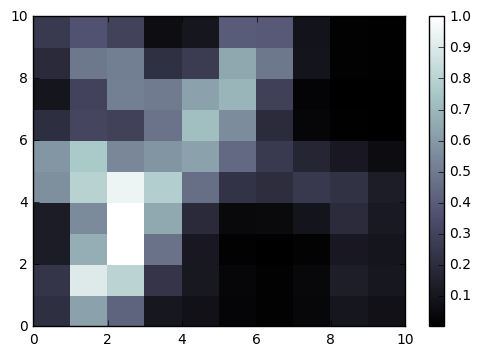

In [1]:
from __future__ import print_function
#from SOM_Trianing import som
import numpy as np
from group_analysis import *

from grouping import group_users
from modules.amazon_parser import *


X = np.array(get_all_scores())

# Training the SOM
# We will use MiniSom 1.0
from minisom import MiniSom
som = MiniSom(x = 10, y = 10, input_len = 9, sigma = 1.0, learning_rate = 0.5)
som.random_weights_init(X)
som.train_random(data = X, num_iteration = 10)


som_distance = som.distance_map().T
#print('som map', som_distance)

# Detecting the fake groups and reviewers
mappings = som.win_map(X)
print('size of the SOM map', len(mappings))
text_file = open("mappings.txt", "w")
text_file.write("winning map is %s" % mappings)
text_file.close()

# List of fake review group IDs
faker_list = []
for i in xrange(len(som_distance)):
	for j in xrange(len(som_distance[0])):
		if som_distance[i][j] > 0.8:
			fake_groups = mappings[(i,j)]
			for group in fake_groups:
				fake_group_ID = group[0]
				faker_list.append(fake_group_ID)
print('list of fake group IDs is\n', faker_list)



# Visualizing the results (SOM in a 2-D plot)
from pylab import bone, pcolor, colorbar, plot, show
bone() # creates a white window
pcolor(som.distance_map().T)
colorbar()
markers = ['o', 's']
colors = ['r', 'g']
show()

In [27]:
fake_user_list = []
for faker in faker_list:
    for review in groups[faker]:
        fake_user_list.append(review[0])

print("No. of fake reviewers: ", len(fake_user_list))
print("List of faker reviewers: ", fake_user_list)

No. of fake reviewers:  122
List of faker reviewers:  ['A978NK2I03VUX', 'A1DH4SLEKIULSS', 'A978NK2I03VUX', 'A2PVV34AXUQY6I', 'A978NK2I03VUX', 'A3QI3WXL4RRN5V', 'A978NK2I03VUX', 'A6EDAWAWCSXYF', 'A978NK2I03VUX', 'A26QJRITJCZKGF', 'A3HG83U1Q1PCWM', 'A2N78JDOY2XGWX', 'A3HG83U1Q1PCWM', 'A1BKT41UNXHLXS', 'A3HG83U1Q1PCWM', 'A2PVV34AXUQY6I', 'A3HG83U1Q1PCWM', 'ACPW63TSTRWB4', 'A3HG83U1Q1PCWM', 'A2YA3ZPKGNMZT', 'A3HG83U1Q1PCWM', 'A2TM4803MFMMI5', 'A3HG83U1Q1PCWM', 'A204SNPLP3HEZO', 'A3HG83U1Q1PCWM', 'A14389R7D03CDC', 'A3VWLZX4W65QFT', 'A3EV44UZB77R78', 'A8KUNW3MUOO8J', 'AW567GB6IJL1D', 'A8KUNW3MUOO8J', 'AFG7JK72YC7A0', 'A8KUNW3MUOO8J', 'A16PWO2GG3Y8GN', 'A3M05LFYIBA9D6', 'AOEFYWCVQJEKT', 'A3GCAZ06J38F33', 'A3L8AJSPACYNUH', 'A1Y2VOTOCB2JN6', 'A21PU3AIMWXG45', 'A1Y2VOTOCB2JN6', 'A3VWLDRUL78D92', 'A1Y2VOTOCB2JN6', 'A3O8K9ZKVB72ZC', 'A1Y2VOTOCB2JN6', 'A306QY21ANLAHS', 'A1Y2VOTOCB2JN6', 'AZVYO6XJYSOOI', 'A1Y2VOTOCB2JN6', 'AL0UJC8MT6D6F', 'A6RNLS78EYF1', 'AWABP5PFAYSWG', 'A6RNLS78EYF1', 'ACZNV1I64S2

### 4 Spam Detection using Reviewer Centric Features

Identifying spammers can improve detection of fake reviews, since many spammers share profile characteristics and activity patterns. We have studied various combinations of features engineered from reviewer profile characteristics and behavioral patterns. 

 




In [13]:
import time
from collections import defaultdict
from nltk.stem.porter import *

ps = PorterStemmer()

def parserJSON(path, numLines=None):
    numLines = numLines or len(open(path).read().split("\n")) - 1
    with open(path) as txt:
        reviews = [eval(next(txt)) for x in range(numLines)]
    return reviews

reviews = parserJSON('./library/amazon-review-data.json')

reviewer_collection = defaultdict(lambda: defaultdict(int))

### 4.1 Maximum number of reviews

It was observed that about 75 % of spammers write more than 5 reviews on any given day. Therefore, taking into account the number of reviews a user writes per day can help detect spammers since 90 % of legitimate reviewers never create more than one review on any given day. 

 




In [24]:
# Calculate the average no. of reviews given by a user per day

def maximum_reviews(reviews):
    reviews_per_day = defaultdict(lambda: defaultdict(float))
    avg_reviews_per_day = defaultdict(lambda: defaultdict(float))
    for i in range(len(reviews)):
        day = time.strftime('%Y%m%d', time.localtime(float(reviews[i]["Date"])))
        reviews_per_day[reviews[i]["memberId"]][day] += 1

    for key1 in reviews_per_day:
        for key2 in reviews_per_day[key1]:
            avg_reviews_per_day[key1] =  sum(reviews_per_day[key1].values())/len(reviews_per_day[key1].keys())
    count = 0
    for key in avg_reviews_per_day:
        if avg_reviews_per_day[key] > 5.0:
            count += 1
    return avg_reviews_per_day

### 4.2 Percentage of positive reviews

Approximately 85 % of spammers wrote more than 80 % of their reviews as positive reviews, thus a high percentage of positive reviews might be an indication of an un- trustworthy reviewer. 

 




In [15]:
#Calculate the % of positive reviews given by a user

def pos_reviews(reviews):
    sentiment_reviews = defaultdict(lambda: defaultdict(float))
    for i in range(len(reviews)):
        sentiment_reviews[reviews[i]["memberId"]][reviews[i]["reviewId"]] = reviews[i]["Rate"]
    positive_reviews = defaultdict(lambda: float)

    for key1 in sentiment_reviews:
        count_pos = 0
        for key2 in sentiment_reviews[key1]:
            if sentiment_reviews[key1][key2] > 3:
                count_pos += 1
        positive_reviews[key1] = float(count_pos)/float(len(sentiment_reviews[key1].keys()))
    return positive_reviews

### 4.3 Review Length

The average review length may be an important indication of reviewers with question- able intentions since about 80 % of spammers have no reviews longer than 135 words while more than 92 % of reliable reviewers have an average review length of greater than 200 words. 

 




In [17]:
# Calculate the average review length for each reviewer

def review_length(reviews):
    review_length_collection = defaultdict(lambda: defaultdict(float))
    for i in range(len(reviews)):
        review_length_collection[reviews[i]["memberId"]][reviews[i]["reviewId"]] = len(reviews[i]["reviewText"])
    avg_review_length_collection = defaultdict(lambda: float)
    for key1 in review_length_collection:
        for key2 in review_length_collection[key1]:
            avg_review_length_collection[key1] = float(sum(review_length_collection[key1].values()))/float(len(review_length_collection[key1].keys()))
    return avg_review_length_collection

### 4.4 Reviewer deviation

It was observed that spammers’ ratings tend to deviate from the average review rating at a far higher rate than legitimate reviewers, thus identifying user rating deviations may help in detection of dishonest reviewers. 

 




In [18]:
# Calculate the rating deviation of each user from the average ratings for that product. If the rating deviation
# is greater than -1 or 1, we mark this as a feature of a fake reviewer.

def reviewer_deviation(reviews):
    product_rating = defaultdict(lambda: defaultdict(float))
    for i in range(len(reviews)):
        product_rating[reviews[i]["productId"]]["memberId"] = reviews[i]["Rate"]

    avg_product_rating = defaultdict(lambda: float)

    for key1 in product_rating:
        for key2 in product_rating[key1]:
            avg_product_rating[key1] = float(sum(product_rating[key1].values()))/float(len(product_rating[key1].keys()))

    deviation_member_rating = defaultdict(lambda: defaultdict(float))

    avg_deviation_member_rating = defaultdict(lambda: float)

    for i in range(len(reviews)):
        deviation_member_rating[reviews[i]["memberId"]][reviews[i]["productId"]] = reviews[i]["Rate"] - avg_product_rating[reviews[i]["productId"]]

    for key1 in deviation_member_rating:
        for key2 in deviation_member_rating[key1]:
            avg_deviation_member_rating[key1] = float(sum(deviation_member_rating[key1].values()))/float(len(deviation_member_rating[key1].keys()))

    return avg_deviation_member_rating

### 4.4 Building the Training Data


 




In [34]:
def construct_feature_vector():
    avg_reviews_per_day = maximum_reviews(reviews)
    positive_reviews = pos_reviews(reviews)
    avg_review_length_collection = review_length(reviews)
    avg_deviation_member_rating = reviewer_deviation(reviews)

    training_data = {} 
    count = 0
    mapping_training_id_user_id = {}
    for key in avg_reviews_per_day:
        if key not in training_data:
            training_data[key] = [count]
            mapping_training_id_user_id[count] = key
            count += 1
        if avg_reviews_per_day[key] > 5:
            training_data[key].append(10 * avg_reviews_per_day[key])
        else:
            training_data[key].append(0.1 * avg_reviews_per_day[key])

    for key in positive_reviews:
        if positive_reviews[key] > 0.8:
            training_data[key].append(5 * positive_reviews[key])
        else:
            training_data[key].append(0.2 * positive_reviews[key])

    for key in avg_review_length_collection:
        training_data[key].append( (avg_review_length_collection[key] - 135.0 ))

    for key in avg_deviation_member_rating:
        if abs(avg_deviation_member_rating[key]) > 1.0:
            training_data[key].append(5 * avg_deviation_member_rating[key] )
        else:
            training_data[key].append(0.2 * avg_deviation_member_rating[key]  )
    return training_data, mapping_training_id_user_id


### 5. Clustering


 




## 5.1 . K-Means

We extract the above four features from the data and train the K-Means with the feature vector

 




In [38]:
from sklearn.cluster import KMeans
import numpy as np

training_data = construct_feature_vector()[0]
final_training_data = []
for value in training_data.values():
	final_training_data.append(value[1:])
X = np.array(final_training_data)
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
predictions = kmeans.predict(X)
count_0 = 0
count_1 = 0
fake_reviewers_kmeans = []
for i in range(len(predictions)):
	if predictions[i] == 0:
		count_0 += 1
	if predictions[i] == 1:
		count_1 += 1
	if predictions[i] == 0:
		fake_reviewers_kmeans.append(training_data.keys()[i])

        
print("No of fake reviewers: ", len(fake_reviewers_kmeans))
print("List of fake reviewers are using K-Means: \n\n", fake_reviewers_kmeans)


No of fake reviewers:  830
List of fake reviewers are using K-Means: 

 ['APBO3QZLFQ43I', 'A3O9H969Z41NHC', 'A1UE981WCIK6G8', 'A2SGTIT04WXTW6', 'A5REX2S396SWK', 'A12ERUPEQF5ZPH', 'A3AZZHUNXQTGF1', 'A3KB6X8CJIDKN6', 'A2B0OACD7F4S4V', 'A3HXY49LIYILEW', 'A1X7SXZ2E4BER0', 'A1RDG7F0WEIWPM', 'A3F63RL19TBWN8', 'A2JXOLYPWSA5CG', 'A1LC0BNUZLSTKX', 'AYJJFTLYGZ1W3', 'A3FQ3NGMAPFPX6', 'A3VZC9DWG7XCA2', 'A3ANMKO68DFPT4', 'A14AQIS492FXK1', 'A12T23CEWIDFBV', 'A1D5SIM8QK8A1K', 'A1ZMXQBU0GTBQD', 'A28O4K2LGG90VF', 'AX8R9EQ5A9ADJ', 'A36U192V1PFLF2', 'AC88LCB1T3KKY', 'A3NRLYHS90EQEJ', 'A3FF7FWPNHE8NV', 'A2RW9Z1DL0ZXDW', 'A2JJ7CNNVU7SKI', 'A3LFJXDPD48KRN', 'A2PHROI8LAPHJ4', 'AHBXWRS5HDUM9', 'A3V5YGZI4D5ML2', 'AXZVP3K4THDML', 'ADHXUNQQJQBGT', 'ADMZA44JUM6AS', 'A3N0FDRLK6RAXH', 'A135BB4KQE6NBC', 'A3LPJFCIAJLXQ', 'A3HSKRBKYRCSNS', 'A1JADDWR1H3M0I', 'A1DUOLSRSXTMAB', 'A4APCKB2HJT76', 'A6ZCK8X9SM799', 'A26CGVBWCVCXGS', 'A1DIFL0333QPEB', 'A3VNSULAUIV2JS', 'A2JS06UGC6HY73', 'A3E0PZM8WW8KTE', 'A10XYSYC7N6B9H', 'A1

### 5.2 . Self Organizing Maps


 




In [17]:
from math import sqrt

from numpy import (array, unravel_index, nditer, linalg, random, subtract,
                   power, exp, pi, zeros, arange, outer, meshgrid, dot)
from collections import defaultdict
from warnings import warn


"""
    Minimalistic implementation of the Self Organizing Maps (SOM).
"""


def fast_norm(x):
    """Returns norm-2 of a 1-D numpy array.

    * faster than linalg.norm in case of 1-D arrays (numpy 1.9.2rc1).
    """
    return sqrt(dot(x, x.T))


class MiniSom(object):
    def __init__(self, x, y, input_len, sigma=1.0, learning_rate=0.5, decay_function=None, random_seed=None):
        """
            Initializes a Self Organizing Maps.
            x,y - dimensions of the SOM
            input_len - number of the elements of the vectors in input
            sigma - spread of the neighborhood function (Gaussian), needs to be adequate to the dimensions of the map.
            (at the iteration t we have sigma(t) = sigma / (1 + t/T) where T is #num_iteration/2)
            learning_rate - initial learning rate
            (at the iteration t we have learning_rate(t) = learning_rate / (1 + t/T) where T is #num_iteration/2)
            decay_function, function that reduces learning_rate and sigma at each iteration
                            default function: lambda x,current_iteration,max_iter: x/(1+current_iteration/max_iter)
            random_seed, random seed to use.
        """
        if sigma >= x/2.0 or sigma >= y/2.0:
            warn('Warning: sigma is too high for the dimension of the map.')
        if random_seed:
            self.random_generator = random.RandomState(random_seed)
        else:
            self.random_generator = random.RandomState(random_seed)
        if decay_function:
            self._decay_function = decay_function
        else:
            self._decay_function = lambda x, t, max_iter: x/(1+t/max_iter)
        self.learning_rate = learning_rate
        self.sigma = sigma
        self.weights = self.random_generator.rand(x,y,input_len)*2-1 # random initialization
        for i in range(x):
            for j in range(y):
                self.weights[i,j] = self.weights[i,j] / fast_norm(self.weights[i,j]) # normalization
        self.activation_map = zeros((x,y))
        self.neigx = arange(x)
        self.neigy = arange(y) # used to evaluate the neighborhood function
        self.neighborhood = self.gaussian

    def _activate(self, x):
        """ Updates matrix activation_map, in this matrix the element i,j is the response of the neuron i,j to x """
        s = subtract(x, self.weights) # x - w
        it = nditer(self.activation_map, flags=['multi_index'])
        while not it.finished:
            self.activation_map[it.multi_index] = fast_norm(s[it.multi_index])  # || x - w ||
            it.iternext()

    def activate(self, x):
        """ Returns the activation map to x """
        self._activate(x)
        return self.activation_map

    def gaussian(self, c, sigma):
        """ Returns a Gaussian centered in c """
        d = 2*pi*sigma*sigma
        ax = exp(-power(self.neigx-c[0], 2)/d)
        ay = exp(-power(self.neigy-c[1], 2)/d)
        return outer(ax, ay)  # the external product gives a matrix

    def diff_gaussian(self, c, sigma):
        """ Mexican hat centered in c (unused) """
        xx, yy = meshgrid(self.neigx, self.neigy)
        p = power(xx-c[0], 2) + power(yy-c[1], 2)
        d = 2*pi*sigma*sigma
        return exp(-p/d)*(1-2/d*p)

    def winner(self, x):
        """ Computes the coordinates of the winning neuron for the sample x """
        self._activate(x)
        return unravel_index(self.activation_map.argmin(), self.activation_map.shape)

    def update(self, x, win, t):
        """
            Updates the weights of the neurons.
            x - current pattern to learn
            win - position of the winning neuron for x (array or tuple).
            t - iteration index
        """
        eta = self._decay_function(self.learning_rate, t, self.T)
        sig = self._decay_function(self.sigma, t, self.T) # sigma and learning rate decrease with the same rule
        g = self.neighborhood(win, sig)*eta # improves the performances
        it = nditer(g, flags=['multi_index'])
        while not it.finished:
            # eta * neighborhood_function * (x-w)
            self.weights[it.multi_index] += g[it.multi_index]*(x-self.weights[it.multi_index])
            # normalization
            self.weights[it.multi_index] = self.weights[it.multi_index] / fast_norm(self.weights[it.multi_index])
            it.iternext()

    def quantization(self, data):
        """ Assigns a code book (weights vector of the winning neuron) to each sample in data. """
        q = zeros(data.shape)
        for i, x in enumerate(data):
            q[i] = self.weights[self.winner(x)]
        return q

    def random_weights_init(self, data):
        """ Initializes the weights of the SOM picking random samples from data """
        it = nditer(self.activation_map, flags=['multi_index'])
        while not it.finished:
            self.weights[it.multi_index] = data[self.random_generator.randint(len(data))]
            self.weights[it.multi_index] = self.weights[it.multi_index]/fast_norm(self.weights[it.multi_index])
            it.iternext()

    def train_random(self, data, num_iteration):
        """ Trains the SOM picking samples at random from data """
        self._init_T(num_iteration)
        for iteration in range(num_iteration):
            rand_i = self.random_generator.randint(len(data)) # pick a random sample
            self.update(data[rand_i], self.winner(data[rand_i]), iteration)

    def train_batch(self, data, num_iteration):
        """ Trains using all the vectors in data sequentially """
        self._init_T(len(data)*num_iteration)
        iteration = 0
        while iteration < num_iteration:
            idx = iteration % (len(data)-1)
            self.update(data[idx], self.winner(data[idx]), iteration)
            iteration += 1

    def _init_T(self, num_iteration):
        """ Initializes the parameter T needed to adjust the learning rate """
        self.T = num_iteration/2  # keeps the learning rate nearly constant for the last half of the iterations

    def distance_map(self):
        """ Returns the distance map of the weights.
            Each cell is the normalised sum of the distances between a neuron and its neighbours.
        """
        um = zeros((self.weights.shape[0], self.weights.shape[1]))
        it = nditer(um, flags=['multi_index'])
        while not it.finished:
            for ii in range(it.multi_index[0]-1, it.multi_index[0]+2):
                for jj in range(it.multi_index[1]-1, it.multi_index[1]+2):
                    if ii >= 0 and ii < self.weights.shape[0] and jj >= 0 and jj < self.weights.shape[1]:
                        um[it.multi_index] += fast_norm(self.weights[ii, jj, :]-self.weights[it.multi_index])
            it.iternext()
        um = um/um.max()
        return um

    def activation_response(self, data):
        """
            Returns a matrix where the element i,j is the number of times
            that the neuron i,j have been winner.
        """
        a = zeros((self.weights.shape[0], self.weights.shape[1]))
        for x in data:
            a[self.winner(x)] += 1
        return a

    def quantization_error(self, data):
        """
            Returns the quantization error computed as the average distance between
            each input sample and its best matching unit.
        """
        error = 0
        for x in data:
            error += fast_norm(x-self.weights[self.winner(x)])
        return error/len(data)

    def win_map(self, data):
        """
            Returns a dictionary wm where wm[(i,j)] is a list with all the patterns
            that have been mapped in the position i,j.
        """
        winmap = defaultdict(list)
        for x in data:
            winmap[self.winner(x)].append(x)
        return winmap

### unit tests
from numpy.testing import assert_almost_equal, assert_array_almost_equal, assert_array_equal


class TestMinisom:
    def setup_method(self, method):
        self.som = MiniSom(5, 5, 1)
        for i in range(5):
            for j in range(5):
                assert_almost_equal(1.0, linalg.norm(self.som.weights[i,j]))  # checking weights normalization
        self.som.weights = zeros((5, 5))  # fake weights
        self.som.weights[2, 3] = 5.0
        self.som.weights[1, 1] = 2.0

    def test_decay_function(self):
        assert self.som._decay_function(1., 2., 3.) == 1./(1.+2./3.)

    def test_fast_norm(self):
        assert fast_norm(array([1, 3])) == sqrt(1+9)

    def test_gaussian(self):
        bell = self.som.gaussian((2, 2), 1)
        assert bell.max() == 1.0
        assert bell.argmax() == 12  # unravel(12) = (2,2)

    def test_win_map(self):
        winners = self.som.win_map([5.0, 2.0])
        assert winners[(2, 3)][0] == 5.0
        assert winners[(1, 1)][0] == 2.0

    def test_activation_reponse(self):
        response = self.som.activation_response([5.0, 2.0])
        assert response[2, 3] == 1
        assert response[1, 1] == 1

    def test_activate(self):
        assert self.som.activate(5.0).argmin() == 13.0  # unravel(13) = (2,3)

    def test_quantization_error(self):
        self.som.quantization_error([5, 2]) == 0.0
        self.som.quantization_error([4, 1]) == 0.5

    def test_quantization(self):
        q = self.som.quantization(array([4, 2]))
        assert q[0] == 5.0
        assert q[1] == 2.0

    def test_random_seed(self):
        som1 = MiniSom(5, 5, 2, sigma=1.0, learning_rate=0.5, random_seed=1)
        som2 = MiniSom(5, 5, 2, sigma=1.0, learning_rate=0.5, random_seed=1)
        assert_array_almost_equal(som1.weights, som2.weights)  # same initialization
        data = random.rand(100,2)
        som1 = MiniSom(5, 5, 2, sigma=1.0, learning_rate=0.5, random_seed=1)
        som1.train_random(data,10)
        som2 = MiniSom(5, 5, 2, sigma=1.0, learning_rate=0.5, random_seed=1)
        som2.train_random(data,10)
        assert_array_almost_equal(som1.weights,som2.weights)  # same state after training

    def test_train_batch(self):
        som = MiniSom(5, 5, 2, sigma=1.0, learning_rate=0.5, random_seed=1)
        data = array([[4, 2], [3, 1]])
        q1 = som.quantization_error(data)
        som.train_batch(data, 10)
        assert q1 > som.quantization_error(data)

    def test_train_random(self):
        som = MiniSom(5, 5, 2, sigma=1.0, learning_rate=0.5, random_seed=1)
        data = array([[4, 2], [3, 1]])
        q1 = som.quantization_error(data)
        som.train_random(data, 10)
        assert q1 > som.quantization_error(data)

    def test_random_weights_init(self):
        som = MiniSom(2, 2, 2, random_seed=1)
        som.random_weights_init(array([[1.0, .0]]))
        for w in som.weights:
            assert_array_equal(w[0], array([1.0, .0]))


size of the SOM map 85
No. of fake reviewers:  324
list of fake user IDs is
 ['A1LTOVNOTWKJIX', 'A64QRH4VA23AH', 'A6FXAYBU8ITQU', 'A18XQSJ1UNBYKL', 'A5TIBWA4RTSM4', 'A3P8S4BLKX0CAM', 'A1Z3E21P66F4LQ', 'A2V9G3QLE3F9W7', 'A23TXF3IMGJEDB', 'AW1IUFH2B3QST', 'A3S7GWOH4U2F8U', 'A3A64PIR2AFUQM', 'ABS796L8URBWA', 'A3VUWD6NPNMDGK', 'AFQ25P2YIXP1V', 'AEQNI7LOUQ5TZ', 'A3CHZGRH9SBYEF', 'A3LNSKHTY1AKND', 'A3E4WKIIY8E0KQ', 'A059251711YHIPRS0SYUA', 'AECLNSWVLV9K2', 'A10CN81QQ1Y4ST', 'A1WS9BSEH1MDB6', 'A35AAE6VLMMYMT', 'ATMC1ZGEGITNV', 'A2ZMZCADQD857G', 'A36USFSO5GVXVG', 'A2IIYZXN45QTWS', 'AGJ8Z4CQO8Q0P', 'AQTSB0ZJM11EL', 'A1SL0SGV7TTRP7', 'A3N10UG4EUI60Z', 'A3HVZ9DJRQ1GTP', 'A3KFCFVLAFNNXV', 'AFR8UPYKGDVTW', 'AEA1L9RANYBR9', 'A3QQM9LTTN76JD', 'AS79NXNIUMZG2', 'A1RXTPI4TAR5FH', 'A2ZMLVVC0XKOTO', 'A117QU1W9FGHVN', 'AY6ZF2O9YXR7', 'A1QI8Y93J1QDOA', 'A1O8LSCDDKXA85', 'A2XVCKDDAG64Y1', 'A1L8BYD72EQ36C', 'A10N0NCOH30TBQ', 'A1FUCWU7JANESX', 'A24R999WAHGE7J', 'A32DPS5SPXZZFL', 'A1993291NGEPEU', 'A3FPA1AIVA5U

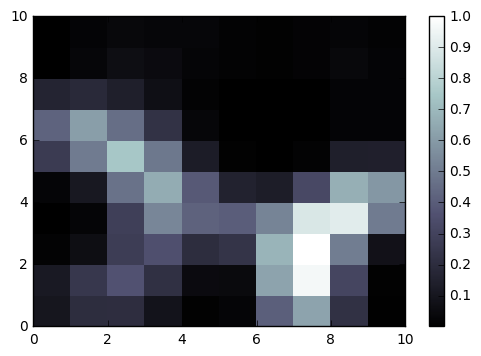

In [20]:
from __future__ import print_function
import numpy as np
X = np.array(construct_feature_vector()[0].values())
mapping = construct_feature_vector()[1]

# Training the SOM
# We will use MiniSom 1.0
from minisom import MiniSom
som = MiniSom(x = 10, y = 10, input_len = 5, sigma = 1.0, learning_rate = 0.5)
som.random_weights_init(X)
som.train_random(data = X, num_iteration = 100)


som_distance = som.distance_map().T

mappings = som.win_map(X)
print('size of the SOM map', len(mappings))
text_file = open("mappings_individual.txt", "w")
text_file.write("winning map is %s" % mappings)
text_file.close()

# List of fake review user IDs
faker_list = []
faker_id = []
for i in xrange(len(som_distance)):
	for j in xrange(len(som_distance[0])):
		if som_distance[i][j] > 0.8:
			fake_reviewers = mappings[(i,j)]
			for user in fake_reviewers:
				faker_id.append(user[0])
				faker_list.append(mapping[user[0]])
                
print('No. of fake reviewers: ', len(faker_list))
print('list of fake user IDs is\n', faker_list)

# Visualizing the results (SOM in a 2-D plot)
from pylab import bone, pcolor, colorbar, plot, show
bone() # creates a white window
pcolor(som.distance_map().T)
colorbar()
markers = ['o', 's']
colors = ['r', 'g']
show()

### Testing


## 5. Result Evaluation & Analysis

The output of the SOM gives the reviewer IDs that are fake.

Initially, by looking at the dataset we had assumed that a few reveiwers were definitely fake reviwers based on the content of their reviews. But, surprisingly the results we obtained were pretty different. Those reviewer IDs were not returned by the SOM as fake ones. This might be due to the fact that it is very difficult to distinguish fake reviewers from normal ones by just observing the content of their reviews.

Grouping reviewers using the criteria that we chose helped us identify reviewer patterns which helped us understand the beahavior of fake reviewers better. This also helped us catch fake reviewers who were difficult to identify by from just the content of their reviews. 

The SOM at times gives different output every time it is run. This is because the weights of the neurons are initialized randomly every time it is run. This is an issue with SOM and the variance can be minimized by letting the SOM run for a large number of iterations. Typically, the number of iterations should be 20 times the size of the dataset. In our dataset the number of groups is about 5000. Hence, we have run the SOM for 100,000 iterations.

Overall, SOM does find fake reviewers but it is pretty unpredictable. We chose SOM as our clustering algorithm because it is great at detecting frauds and is used in detecting credit card frauds. The problem we had was pretty similar but in this case we had to put reviewers into groups and design their feature vectors. Although we had hoped that SOM would work very well to solve our problem but it seems that it requires a lot of dataset, iterations and parameter tuning to detect fake reviewers and reviews.

We also trained KMeans algorithm using reviewer centric features (individual reviewers). The results with K-Means were consistent and did not change as it changed with SOM with different iteration.


### 6 . Conclusion

 So we tried detecting fake reviews on the amazon dataset using different techniques. We first tried grouping potential spammers and clustered them using Self Organizing Maps.

 Number of fake reviewers we got using Group Indicators and SOM - 

 We also tried to detect individual behaviors that are indicative of spammers and tried clustering them using K-Means and SOM.

 Number of fake reviewers (KMeans) - 830

Number of fake reviewers (SOM) - 324

Overall, we found that the results with Self Organizing Maps was a bit unpredictable as we were getting different results each time we ran. With K-Means, we found that the results were consistent.


 




## 7. Reference

[1] http://liu.cs.uic.edu/download/data/

[2] https://www.cs.uic.edu/~liub/publications/WWW-2012-group-spam-camera-final.pdf

[3] https://www.hindawi.com/journals/mpe/2016/4935792/

[4] https://www.cs.uic.edu/~liub/FBS/fake-reviews.html

[5] http://cs231n.github.io/neural-networks-1/

[6] http://www.bbc.com/news/technology-22166606


# {delete before submission} Proposal -- You may need to refer to this paragraph

Prior works on opinion spam focused on detecting fake reviews and individual fake reviewers. However, a fake reviewer group (a group of reviewers who work collaboratively to write fake reviews) is even more damaging as they can take total control of the sentiment on the target product due to its size. Therefore, we are going to follow our base paper trying to identify fake reviews by clustering fake spammers into groups, which are also called group spammers[1]. Group spamming refers to a group of reviewers writing fake reviews together to promote or to demote some target products. The base paper[1] we choose has done experiments that show it is hard to detect spammer groups using review content features or even indicators for detecting abnormal behaviors of individual spammers because a group has more manpower to post reviews and thus, each member may no longer appear to behave abnormally. A group of reviewers refers to a set of reviewer-ids. The actual reviewers behind the ids could be a single person with multiple ids (sockpuppet), multiple persons, or a combination of both.


Therefore, we will also implement a relation-based model “GSRank” described in [2] using an Artificial Neural Network [5] as the following figure1. The GS rank algorithm is an unsupervised iterative algorithm that works differently from the traditional supervised learning approach to spam detection. The paper [2] has concluded after experiments that “GSRank” performs better than the state-of-the-art supervised classification, regression, and learning to rank algorithms. Basically, we also follow this paper [2] to build a more effective model which can consider the inter-relationship among products, groups, and group members in computing group spamicity. In other words, we will try to reimplement the paper from scratch. In conclusion, after getting two different result as we mentioned above, we will evaluate with Precision, Recall and NDCG.




# {delete before submission}  Requirement



Your main deliverable is your project notebook. This will act as both a written report plus a walkthrough of your code. This is the critical piece that will document and detail your project experience. We expect your project notebook to tell us the story of your project -- from initial question and data collection, to initial exploratory data analysis, perhaps to a revised question, to analyses, visualizations, and key takeaways.


Note that we do not want to see a completely raw, moment-by-moment accounting of your project (include all 99 missteps and dead-ends); rather, you should carefully put together your final project notebook for submission that captures the key steps along the way.
